# Lab 10 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

To download the dataset [click here](https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats)

For picture classification problems in computer vision and machine learning, the Dogs vs. Cats dataset is a well-known standard dataset. It has thousands of pictures of cats and dogs in it. Developing a classifier that can correctly differentiate between photos of dogs and photos of cats. This dataset has 25,000 images in total. We are using only 5000 images out fo which 2000 images for training, 1000 images for validation and 2000 images for testing.

In [1]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import pandas as pd
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, f1_score,classification_report,precision_recall_curve

# OBTAIN THE DATASET

PATH TO THE DATASET

In [2]:
data_folder = pathlib.Path('C:/Users/HP/Downloads/Cat_dog_datatset')

In [3]:
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


DATASET TYPE

In [4]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

DATATSET SHAPES AND LABELS

In [5]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [6]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1])>

# EXPLORATORY DATA ANALYSIS

DISPLAYING 20 IMAGES FROM THE TRAINING DATATSET

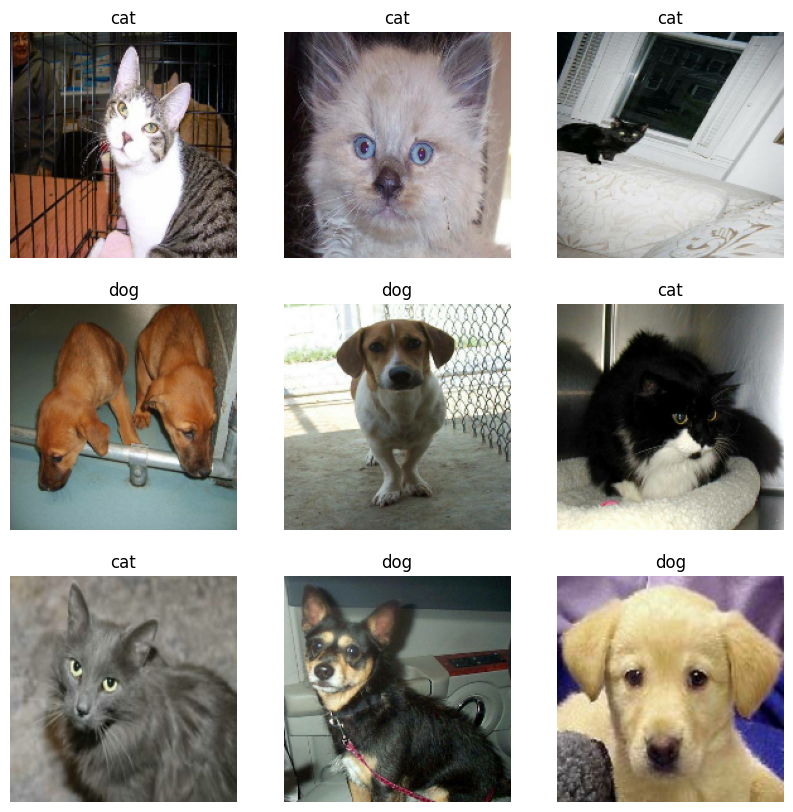

In [7]:
plt.figure(figsize=(10, 10))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

CLASS DISTRIBUTION OF THE DATASET

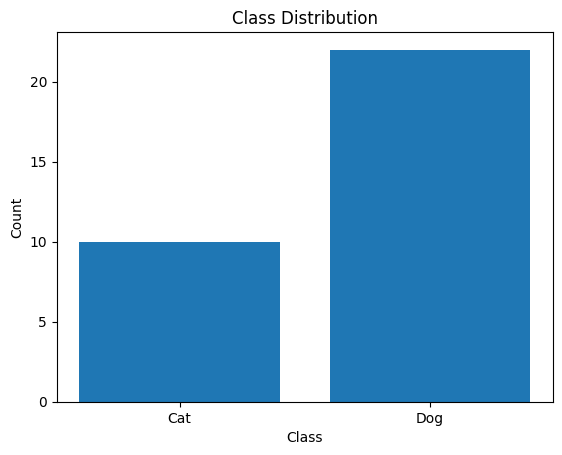

In [8]:
class_names = ['Cat', 'Dog']
class_counts = [sum(labels_batch.numpy() == i) for i in range(len(class_names))]
plt.bar(class_names, class_counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

DISTRIBUTION OF PIXEL VALUES

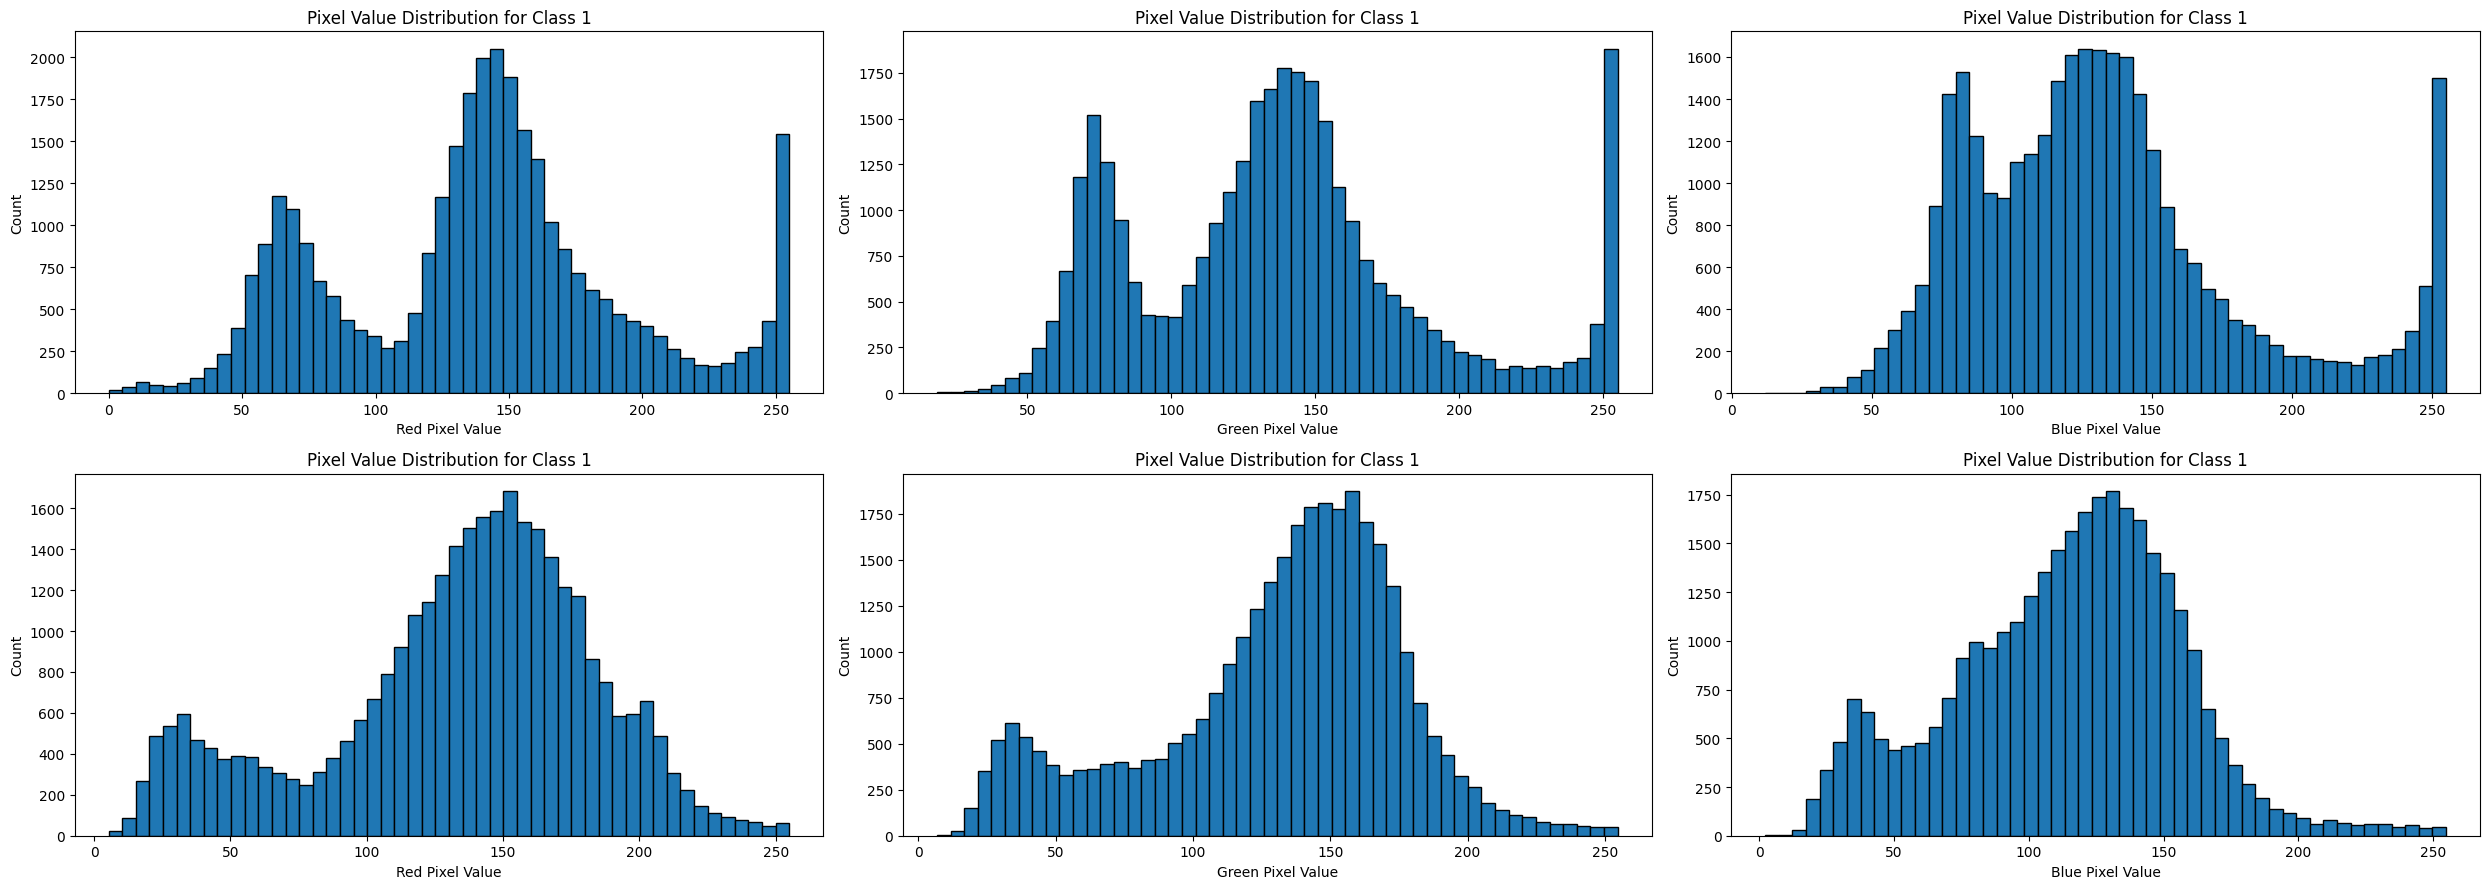

In [9]:
# Plot the distribution of pixel values
fig, axes = plt.subplots(2, 3, figsize=(25, 9))

# pixel distribution for class 1
for i in range(3):
    axes[0, i].hist(data_batch[0, :, :, i].numpy().flatten(), bins=50, edgecolor='black')
    axes[0, i].set_title(f'Pixel Value Distribution for Class {labels_batch[0]}')
    if i == 0:
        axes[0, i].set_xlabel('Red Pixel Value')
    elif i == 1:
        axes[0, i].set_xlabel('Green Pixel Value')
    else:
        axes[0, i].set_xlabel('Blue Pixel Value')
    axes[0, i].set_ylabel('Count')

# pixel distribution for class 0
for i in range(3):
    axes[1, i].hist(data_batch[3, :, :, i].numpy().flatten(), bins=50, edgecolor='black')
    axes[1, i].set_title(f'Pixel Value Distribution for Class {labels_batch[3]}')
    if i == 0:
        axes[1, i].set_xlabel('Red Pixel Value')
    elif i == 1:
        axes[1, i].set_xlabel('Green Pixel Value')
    else:
        axes[1, i].set_xlabel('Blue Pixel Value')
    axes[1, i].set_ylabel('Count')

plt.tight_layout()
plt.show()

INSIGHT: The greatest pixel value of 255 in each channel indicates which colour channel is dominant. In comparison to green and blue, colour channel red has a higher dominance.

DATA AUGMENTATION

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

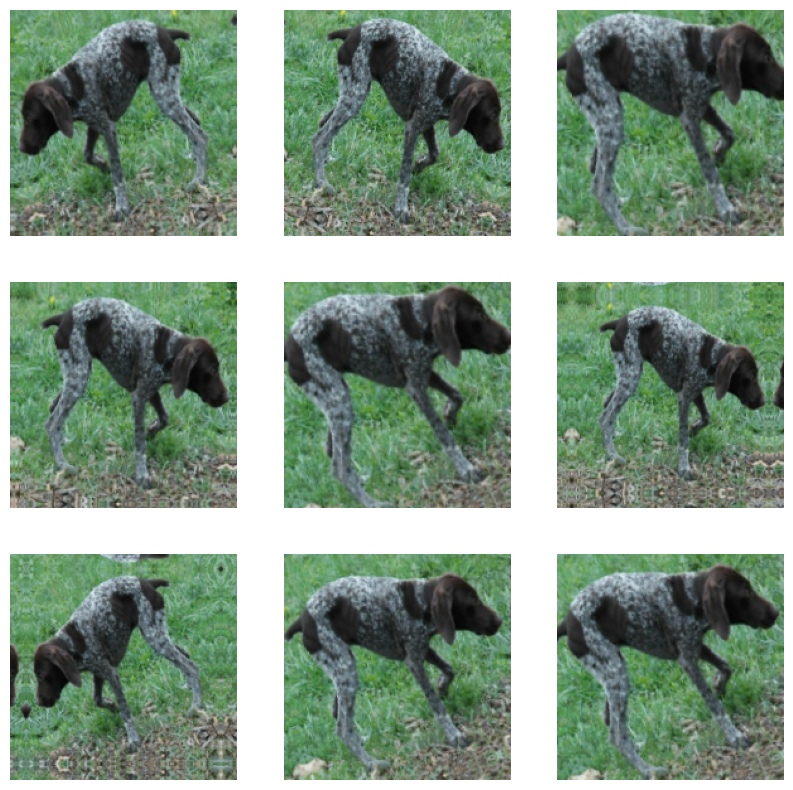

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

INSIGHT: In machine learning and deep learning, the approach known as "data augmentation" is used to apply several alterations to the preexisting data in order to artificially expand its size for training purposes. By exposing the model to more varied variants of the input data, this helps to improve the model's performance and generalisation.

# TRAIN TWO NETWORKS

#### 1. DEFINE A NEURAL NETWORK

In [12]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

MODEL SUMMARY

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

COMPILING THE MODEL

In [14]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

CALLBACK TO SAVE THE BEST MODEL

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)  

Epoch 1/20


63/63 [==============================] - 103s 2s/step - loss: 0.7025 - accuracy: 0.5175 - val_loss: 0.6918 - val_accuracy: 0.6060
Epoch 2/20
63/63 [==============================] - 110s 2s/step - loss: 0.6921 - accuracy: 0.5335 - val_loss: 0.7340 - val_accuracy: 0.5000
Epoch 3/20
63/63 [==============================] - 101s 2s/step - loss: 0.6868 - accuracy: 0.5760 - val_loss: 0.6691 - val_accuracy: 0.6230
Epoch 4/20
63/63 [==============================] - 103s 2s/step - loss: 0.6538 - accuracy: 0.6210 - val_loss: 0.6340 - val_accuracy: 0.6430
Epoch 5/20
63/63 [==============================] - 123s 2s/step - loss: 0.6198 - accuracy: 0.6565 - val_loss: 0.6085 - val_accuracy: 0.6560
Epoch 6/20
63/63 [==============================] - 125s 2s/step - loss: 0.5965 - accuracy: 0.6800 - val_loss: 0.6185 - val_accuracy: 0.6770
Epoch 7/20
63/63 [==============================] - 118s 2s/step - loss: 0.5558 - accuracy: 0.7150 - val_loss: 0.5825 - val_accuracy: 0.6880
Epoch 8/20
63/63 [======

PLOTTING TRAINING AND VALIDATION LOSS

In [ ]:
def plot_training_val_loss(model_history):
    history_dict = model_history.history
    plt.figure(figsize=(9, 5))
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Training and validation loss")
    plt.tight_layout()

plot_training_val_loss(history)

NameError: name 'history' is not defined

PLOTTING TRAINING AND VALIDATION ACCURACY

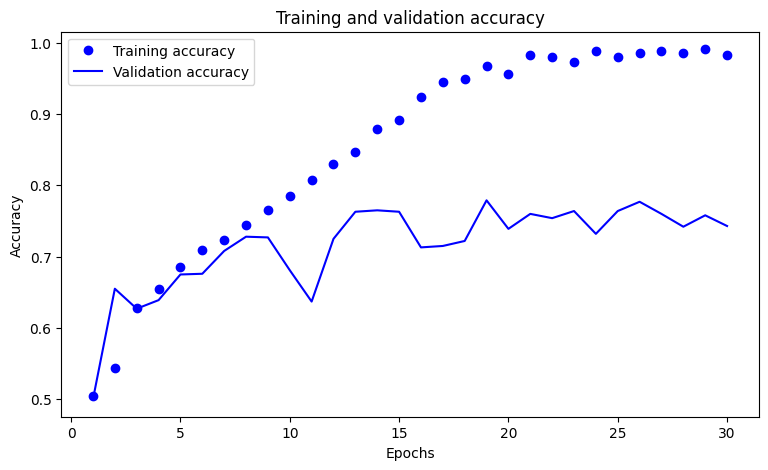

In [ ]:
def plot_training_val_accuracy(model_history):
    history_dict = model_history.history
    plt.figure(figsize=(9, 5))
    acc_values = history_dict["accuracy"]
    val_acc_values = history_dict["val_accuracy"]
    epochs = range(1, len(acc_values) + 1)
    plt.plot(epochs, acc_values, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Training and validation accuracy")

plot_training_val_accuracy(history)

#### 2. FINE-TUNE VGG16

LOADING PRE-TRAINED VGG16

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

FREEZING THE WEIGHT

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

SUMMARY

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

TOP FULLY CONNECTED LAYERS

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
VGG16_Pre_trained_model = keras.Model(inputs, outputs)

NameError: name 'data_augmentation' is not defined

SUMMARY

In [ ]:
VGG16_Pre_trained_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                           

COMPLIING THE MODEL

In [ ]:
VGG16_Pre_trained_model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

NameError: name 'VGG16_Pre_trained_model' is not defined

CALLBACK

In [ ]:
VGG_16_callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/models/VGG16_fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

VGG16_model_history = VGG16_Pre_trained_model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=VGG_16_callbacks)

NameError: name 'keras' is not defined

PLOTTING TRAINING AND VALIDATION LOSS

In [ ]:
def plot_training_val_loss(model_history):
    history_dict = model_history.history
    plt.figure(figsize=(9, 5))
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Training and validation loss")
    plt.tight_layout()

plot_training_val_loss(VGG16_model_history)

PLOTTING TRAINING AND VALIDATION ACCURACY

In [ ]:
def plot_training_val_accuracy(model_history):
    history_dict = model_history.history
    plt.figure(figsize=(9, 5))
    acc_values = history_dict["accuracy"]
    val_acc_values = history_dict["val_accuracy"]
    epochs = range(1, len(acc_values) + 1)
    plt.plot(epochs, acc_values, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Training and validation accuracy")

plot_training_val_accuracy(VGG16_model_history)

# Explore the relative performance of the models

#### ACCURACY OF VANILLA CNN MODEL

In [ ]:
vanilla_model_path = 'C:/Users/HP/Downloads/CSCN8010/LAB10_CSCN8010/models/convnet_from_scratch.keras'
vanilla_model = tf.keras.models.load_model(vanilla_model_path)
test_loss, test_accuracy = vanilla_model.evaluate(test_dataset)
print(f"Test loss of vanilla model: {test_loss:.3f}")
print(f"Test Accuracy of vanilla model: {test_accuracy:.3f}")

INSIGHTS:<br>
About 59.5% of tests were completed with a loss of 0.6590 for the vanilla model. The model accurately predicts the outcome around 60.11% of the time during training and roughly 59.5% of the time on the test data that hasn't been seen before, according to the accuracy measure.

#### ACCURACY OF VGG16 MODEL

In [ ]:
best_VGG_16_CNN_model = keras.models.load_model(
    "C:/Users/HP/Downloads/CSCN8010/LAB10_CSCN8010/models/VGG16_fine_tuning.keras")
vgg_loss, vgg_accuracy= best_VGG_16_CNN_model.evaluate(test_dataset)
print(f"Test loss of VGG16 model: {test_loss:.3f}")
print(f"Validation accuracy of VGG16 model: {test_accuracy:.3f}")

INSIGHTS:<br>
About 59.5% of tests were completed with a loss of 0.6590 for the VGG16 model. The model accurately predicts the outcome around 60.11% of the time during training and roughly 59.5% of the time on the test data that hasn't been seen before, according to the accuracy measure.

#### CONFUSION MATRIC

In [ ]:
# Get true labels and model predictions
y_true = np.concatenate([labels.numpy() for _, labels in test_dataset])
y_pred = np.round(vanilla_model.predict(test_dataset)).flatten()

# Compute metrics
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

#### PRECISION, RECALL, F1-SCORE

In [ ]:
y_true = np.concatenate([y for _, y in test_dataset], axis=0)  
y_pred_probs = vanilla_model.predict(test_dataset) 

threshold = 0.5
y_pred = (y_pred_probs > threshold).astype(int)  

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')

INSIGHTS:<br>
1. Precision: 0.481 - This indicates that the model is accurate around 48.1% of the time when predicting the positive class.
2. Recall: 0.523 - This indicates that 52.3% of real positive examples are properly identified by the model. 
3. F1-Score: 0.501 - A score of 0.501 indicates that the model has a balanced trade-off between precision and recall, indicating reasonable accuracy.

#### PRECISION-RECALL CURVE

In [ ]:
# Get true labels and model predictions
y_true = np.concatenate([labels.numpy() for _, labels in test_dataset])
y_pred = np.round(vanilla_model.predict(test_dataset)).flatten()

# Compute metrics
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

INSIGHT:<br>
When compared to Vanilla CNN, Pre-trained VGG-16 performs better and has a larger area under the curve, indicating that it is the superior model.

#### Explore specific examples in which the model failed to predict correctly.

PREDICTION FAILED BY VANILLA MODEL

INSIGHTS:<br>
This model predicts total 441 images wrong. It is unable to predict the image of a dog and only predicts the image of a cat. In such cases where a cat is in human's hand, the model predict the image as the image of a dog.

PREDICTION FAILED BY VGG16 MODEL

INSIGHTS:<br>
The pre-trained VGG16 model predict total 51 images wrong out of the total 2000 images. It is not able to predict the hand-drawn images of cat and dog. Not to able to predict if the image is not clear or there are more than one cats or dogs in a single image. Unable to predict if cat and dog if human is also present along with.

# CONCLUSION

1. ACCURACY:
For vanilla model the test loss observed is 0.572 and test acuuracy is 0.731 For VGG16 model the test loss observed is 0.572 and test accuracy is 0.731
2. Precision: 0.481 - This indicates that the model is accurate around 48.1% of the time when predicting the positive class.
3. Recall: 0.375 - This indicates that 37.5% of real positive examples are properly identified by the model.
4. F1-Score: 0.424 - A score of 0.424 indicates that the model has a balanced trade-off between precision and recall, indicating reasonable accuracy.
5. To identify photos of dogs and cats, we have trained a Vanilla CNN model in this lab and fine-tuned an existing VGG-16 model.
6. We also used approaches for data-augmentation and rescaling the photos.
7. Between the two models In comparison to Vanilla CNN, pre-trained VGG-16 is the best model and performs well.